## Bayesian inference of optical trap stiffness and diffusion coefficient
The Langevin equation for a Brownian particle confined in a potential $U$ is given by

$$ m\dot v + \gamma v + \nabla U = \xi$$

where $\xi(t)$ is a zero-mean Gaussian white noise with variance

$$ \langle \xi(t)\xi(t') \rangle = 2k_BT\gamma\delta(t - t')$$

In the limit of vanishing inertia and a harmonic force, we obtain the overdamped Langevin equation

$$ \dot x = -\frac{k}{\gamma}x + \sqrt{\frac{2k_BT}{\gamma}} \zeta(t) $$ 

where $\zeta(t)$ is now a zero mean Gaussian white noise with unit variance. This is the Ornstein-Uhlenbeck process, whose sample paths obey the Ito stochastic differential equation, 

$$ dx = -\lambda x dt + \sigma dW $$


where $W$ is the Wiener process and $\lambda = k/\gamma$ and $\sigma = \sqrt{\frac{2k_BT}{\gamma}}$. From the Einstein relation $D = \frac{k_BT}{\gamma}$ it follows that the diffusion coefficient is

$$  \sigma^2 = 2D $$


From equipartition, ${1\over 2}k\langle x^2 \rangle = {1\over 2} k_BT$, and combining with the Einstein relation for
$D$ and the definition of the mean regression rate, we have two *independent* estimates for the stiffness (in units of k_BT):

$$ \frac{k}{k_BT} = \frac{\lambda}{D}= \frac{1}{\langle x^2 \rangle} $$


From the Markov property of the process, the probability of obtaining the sample $X \equiv (x_1, x_2, \ldots, x_N)$ for a given value of the parameters is

$$ P(X|\lambda, D) = \prod_{n=1}^{N-1} P(x_{n+1}|x_n)P(x_1)$$ 

The probability $P(\lambda, D | X)$ of the parameters, given the sample can then be computed in terms of the above probability using Bayes theorem. The transition and stationary probabilities for the Ornstein-Uhlenbeck process are known exactly.

The code below demonstrates the use of the [pybisp](https://github.com/ronojoy/pybisp) package to estimate the trap stiffness and particle friction from  discrete measurements of the sample path of an optically trapped Brownian particle.

In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pybisp as pb
%matplotlib inline

In [2]:
# read in the data file sampled at 1.5 kHz over 20 seconds
datafile='/Users/rjoy/GitHub/pybisp/data/optical-trap.xlsx'
data = pd.ExcelFile(datafile).parse()
sample_path = data.values

# set some useful parameters
dt = 1.0/1500; t = np.arange(0, data.size*dt, dt)

k_B = 1.38064881313131e-17  # Boltzmann constant(N micron/Kelvin)
T = 300                     # temperature(Kelvin)

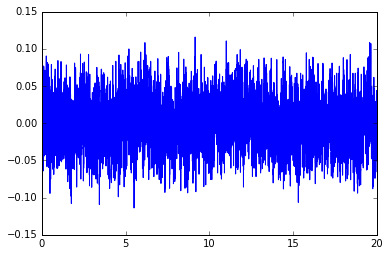

In [3]:
plt.plot(t, sample_path);

In [4]:
# MAP estimate assuming an Ornstein-Uhlenbeck process
ou = pb.ou.Inference(sample_path, dt)
L, D, K = ou.mapEstimate() 
k = K * (k_B*T) # physical value of the stiffness (N /micron)
print 'The best estimate for the stiffness is', k, 'N/muM '

The best estimate for the stiffness is 4.71653700282e-12 N/muM 


In [5]:
# MAP estimate assuming equipartition
eqp = pb.equipartition.Inference(sample_path)
K = eqp.mapEstimate()
k = K * (k_B*T) # physical value of the stiffness (N /micron)
print 'The best estimate for the stiffness is', k, 'N/muM '

The best estimate for the stiffness is 4.71762258033e-12 N/muM 


The two *independent* methods are in excellent agreement. This self-consistency indicates that Ornstein-Uhlenbeck process is a good model for the data.

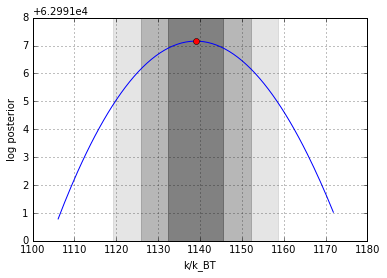

In [9]:
# error bars and posterior probability plots
dK = eqp.errorBar() 

# plot the logposterior in the '5 sigma' interval
# the 1, 2 and 3 sigma intervals are shaded
# the map estimate is shown with the red dot
eqp.plotLogProb(5)

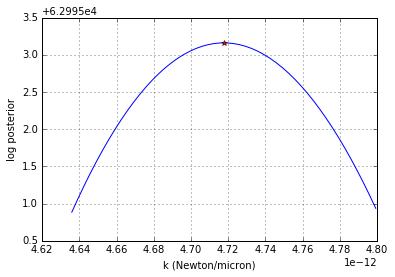

In [10]:
# plot logposterior physical units around the '3 sigma' interval
kk = np.linspace(K - 3.0*dK, K + 3.0*dK)
plt.plot(kk*(k_B*T), eqp.logProb(kk), K*(k_B*T), eqp.logProb(K), 'r*');
plt.grid(), plt.xlabel('k (Newton/micron)'), plt.ylabel('log posterior');

The log of the posterior proability drops sharply around the maximum indicated by the red star. From the precise numbers, we can say that with a probability of 99.7% the value of the stiffness lies betwen 4.63 and 4.80 N/muM. The Bayesian credible interval, rather than the frequentist confidence interval,  is the relevant quantity for estimation of physical parameters, as it alone can be interpreted in the sense stated above. 